# Pima Indian Diabetes Data
### Adapted from Pluralsight course "Understanding Machine Learning with Python" by Jerry Kurata

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings ; warnings.filterwarnings('ignore')

# for inline plotting
%matplotlib inline

## Load .csv data and review it -- note zero-indexing by Pandas module

In [2]:
df = pd.read_csv("./data/pima-data.csv")

In [3]:
df.shape

(768, 10)

In [4]:
df.head(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True



## Check for null values

In [5]:
df.isnull().values.any()

False


## Check whether any columns are correlated

In [6]:
def plot_corr(df, size=11):
    """
    Plots correlation matrix for each pair of columns    
    """
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (size,size))
    cax = ax.matshow(corr)
    fig.colorbar(cax, fraction=0.0458, pad=0.04)
    plt.xticks(np.arange(len(corr.columns)), corr.columns)
    plt.yticks(np.arange(len(corr.columns)), corr.columns)

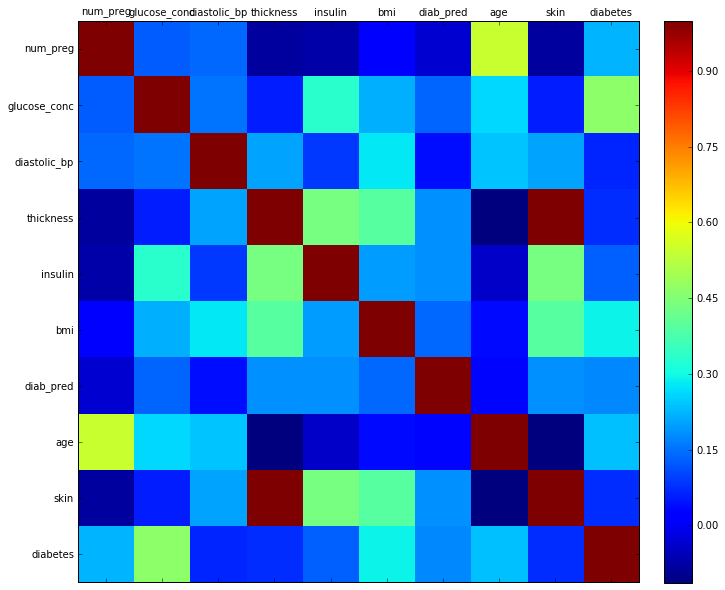

In [7]:
plot_corr(df)

### Clearly the thickness and skin columns are correlated, get rid of one of them

In [8]:
del df['skin']

In [9]:
df.head(3)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,True
1,1,85,66,29,0,26.6,0.351,31,False
2,8,183,64,0,0,23.3,0.672,32,True


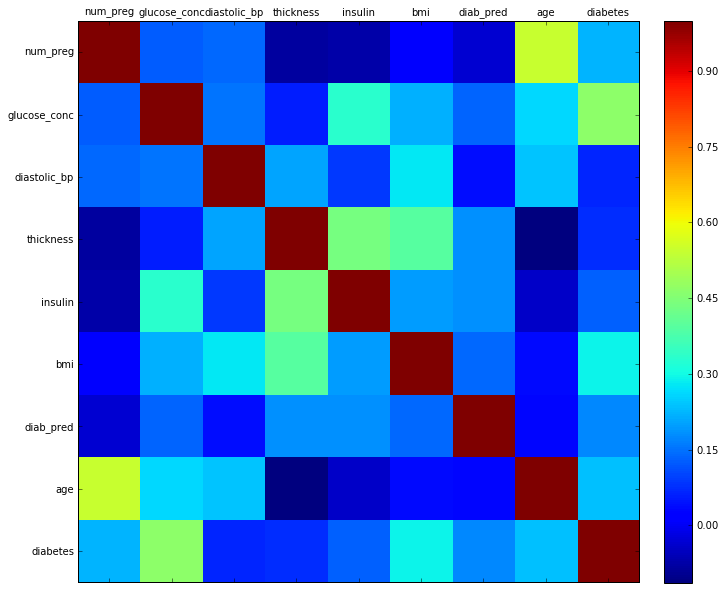

In [10]:
# double-check
plot_corr(df)

## Check Data Types

In [11]:
# Change last column "diabetes" from text to boolean
# Easiest to use a Panda map method instead of iterating (nice)
diabetes_map = {True: 1, False: 0}
df['diabetes'] = df['diabetes'].map(diabetes_map)

In [12]:
num_true = len(df.loc[df['diabetes'] == True])
num_false = len(df.loc[df['diabetes'] == False])

print("Number of True Cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/(num_true+num_false))*100))
print("Number of False Cases:  {0} ({1:2.2f}%)".format(num_false, (num_false/(num_true+num_false))*100))

Number of True Cases:  268 (34.90%)
Number of False Cases:  500 (65.10%)


## Split the data 
70% to train on, 30% to test on

In [13]:
from sklearn.cross_validation import train_test_split

feature_col_names = ['num_preg','glucose_conc','diastolic_bp','thickness','insulin','bmi','diab_pred','age']
predicted_class_names = ['diabetes']

X = df[feature_col_names].values     # predictor feature columns (8 x m)
y = df[predicted_class_names].values # predicted class (1=True, 0=False) column (1 x m)
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
X.shape, X_train.shape, X_test.shape

((768, 8), (537, 8), (231, 8))

Check to ensure actually got the desired 70/30 split

In [15]:
print("{0:0.2f}% in training set".format( (1.*len(X_train))/len(df.index)*100 ) )
print("{0:0.2f}% in test set".format( (1.*len(X_test))/len(df.index)*100 ) )

69.92% in training set
30.08% in test set


### IMPORTANT: *Within* each category of True/False did-develop-diabetes, did we get a 70/30 split?  

In [16]:
print("Original True  :  {0} ({1:.2f}%)".format(len(df.loc[df['diabetes'] == 1]), len(df.loc[df['diabetes'] == 1])/len(df.index)*100. ))
print("Original False :  {0} ({1:.2f}%)".format(len(df.loc[df['diabetes'] == 0]), len(df.loc[df['diabetes'] == 0])/len(df.index)*100. ))
print('')
print("Training True  :  {0} ({1:.2f}%)".format(len(y_train[y_train[:] == 1]), len(y_train[y_train[:] == 1])/len(y_train)*100. ))
print("Training False :  {0} ({1:.2f}%)".format(len(y_train[y_train[:] == 0]), len(y_train[y_train[:] == 0])/len(y_train)*100. ))
print('')
print("Test True  :  {0} ({1:.2f}%)".format(len(y_test[y_test[:] == 1]), len(y_test[y_test[:] == 1])/len(y_test)*100. ))
print("Test False :  {0} ({1:.2f}%)".format(len(y_test[y_test[:] == 0]), len(y_test[y_test[:] == 0])/len(y_test)*100. ))

Original True  :  268 (34.90%)
Original False :  500 (65.10%)

Training True  :  188 (35.01%)
Training False :  349 (64.99%)

Test True  :  80 (34.63%)
Test False :  151 (65.37%)


### Both Training and Test sets follow the original data frame's breakdown of True vs. False cases.
## (NOTE:  There is an imbalance between True and False cases within the Training and Test sets.  Keep that in mind, it is addressed later below.)

### Missing Values:  Are there hidden missing values?   e.g., missing values now masquerading as zeros?

Count how many rows (for each column/feature) have zeros in them

In [17]:
print("# of total rows in the dataframe:    {0}".format(len(df)))
print("# of rows missing for glucose_conc:  {0}".format(len(df.loc[df['glucose_conc'] == 0])))
print("# of rows missing for diastolic_bp:  {0}".format(len(df.loc[df['diastolic_bp'] == 0])))
print("# of rows missing for thickness:     {0}".format(len(df.loc[df['thickness']    == 0])))
print("# of rows missing for insulin:       {0}".format(len(df.loc[df['insulin']      == 0])))
print("# of rows missing for bmi:           {0}".format(len(df.loc[df['bmi']          == 0])))
print("# of rows missing for diab_pred:     {0}".format(len(df.loc[df['diab_pred']    == 0])))
print("# of rows missing for age:           {0}".format(len(df.loc[df['age']        == 0])))

# of total rows in the dataframe:    768
# of rows missing for glucose_conc:  5
# of rows missing for diastolic_bp:  35
# of rows missing for thickness:     227
# of rows missing for insulin:       374
# of rows missing for bmi:           11
# of rows missing for diab_pred:     0
# of rows missing for age:           0


#### That's too many rows to throw out, so *impute with the mean* where missing

In [18]:
from sklearn.preprocessing import Imputer

# Impute with mean for all 0 readings (columns are axis=0)
fill_0 = Imputer(missing_values=0, strategy='mean',axis=0)

X_train = fill_0.fit_transform(X_train)
X_test = fill_0.fit_transform(X_test)

## Train with Naive Bayes algorithm

### Assume the features each follow a Gaussian dist around their mean

In [19]:
from sklearn.naive_bayes import GaussianNB

# create a Gaussian Naive Bayes model object and train it
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None)

### Test the model's performance on the *training* data first

In [20]:
# predict the values using the training data
nb_predict_train = nb_model.predict(X_train)

# performance metrics library
from sklearn import metrics

# Use metrics.accuracy_score to compare y_train (what our model is SUPPOSED to predict from this training data)
# versus nb_predict_train (what our model actually predicts from this training data)
print("Accuracy:  {0:.4f} \n".format(metrics.accuracy_score(y_train, nb_predict_train) ))

Accuracy:  0.7542 



### Okay, how does the model's perform on the test data?

In [21]:
# predict the values using the training data
nb_predict_test = nb_model.predict(X_test)

print("Accuracy:  {0:.4f} \n".format(metrics.accuracy_score(y_test, nb_predict_test) ))

Accuracy:  0.7359 



### That was the goal-- at least 70% accuracy at predicting whether likely to develop diabetes . . . but beware!  Look at the Confusion Matrix and compare to what ideal confusion matrix would be for the Test data (in which we already know there are 80 True and 151 False).  
### In the Confusion matrix:
### Rows are actual values:  Top row is actual true, and bottom row is actual false.
### Columns are predicted values:   Left col is predicted true, right col is predicted false.   So the elements are:  
TP = True Positive  = the person actually developed diabetes AND was predicted to develop diabetes

TN = True Negative  = the person did not develop diabetes and was correctly predicted to NOT develop diabetes 

FP = False Positive = the person did not develop diabetes BUT was INCORRECTLY predicted to develop diabetes

FN = False Negative = the person actually developed diabetes BUT was INCORRECTLY predicted to NOT develop diabetes

A "perfect" classifier's confusion matrix for our actual 80 True, actual 151 False in the test data set would be:

$\begin{bmatrix} TP & FN \\ FP & TN \end{bmatrix}$ 

Plugging in values from above:

$\begin{bmatrix} 80 & 00 \\ 00 & 151 \end{bmatrix}$

In [22]:
print("Confusion Matrix (set 1=True to upper left, 0=False to lower right)")
metrics.confusion_matrix(y_test, nb_predict_test, labels=[1,0])

Confusion Matrix (set 1=True to upper left, 0=False to lower right)


array([[ 52,  28],
       [ 33, 118]])

#### So our classifier is not perfect . . . no classifier is, but is it good enough to get us 70% accuracy in predicting likelihood?

### Generate a Classification Report to get some more statistics from the confusion matrix

In [23]:
print(metrics.classification_report(y_test, nb_predict_test, labels=[1,0]))

             precision    recall  f1-score   support

          1       0.61      0.65      0.63        80
          0       0.81      0.78      0.79       151

avg / total       0.74      0.74      0.74       231



#### *Recall* is the "true positive rate" or the "sensitivity":  It is how well the model is correctly predicting diabetes when the individual in fact has diabetes.  That is the number of true positives divided by the total people who in fact have it (true positives + false negatives all actually have diabetes):  

$\mbox{Recall} = \frac{TP}{TP+FN} = \frac{52}{52+28} = 0.65$

We are 65%, below the desired 70%.  Increasing recall would come through decreasing false negatives (FN).

#### *Precision* is a positive predictor value:  It is how often the patient actually had diabetes when the model said they would.  That is the number of true positives divided by the total people we said have it (true positives + false positives = all the people *we said* have diabetes):

$\mbox{Precision} = \frac{TP}{TP+FP} = \frac{52}{52+33} = 0.61$

Increasing precision would come through decreasing false positives (FP).


### ENSEMBLE METHOD:  Try Random Forest, which is one Ensemble Method option.
#### Advantages:  RF is an ensemble method-- it fits multiple Decision Trees to subsets of the data, so that might perform better than Naive Bayes (and of course a single decision tree).
#### Disadvantages:  Even though it is an ensemble method, still have to watch out for overfitting . . . .

### Train an RF classifier on the training data-- Note that its hyperparameter oob_score we are setting to True (but turns out not to help, same result if set to False, I checked)

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, oob_score=True)  # Creates a Random Forest object
rf_model.fit(X_train,y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

### Test it out the *training* data

In [25]:
# predict the values using the training data
rf_predict_train = rf_model.predict(X_train)

print("Accuracy:  {0:.4f} \n".format(metrics.accuracy_score(y_train, rf_predict_train) ))

Accuracy:  0.9870 



Suspiciously high . . .
### Test it out on the *test* data

In [26]:
# predict the values using the test data
rf_predict_test = rf_model.predict(X_test)

print("Accuracy:  {0:.4f} \n".format(metrics.accuracy_score(y_test, rf_predict_test) ))

Accuracy:  0.7100 



There should not be such a big drop in performance . . . check the recall

In [27]:
print(metrics.confusion_matrix(y_test, rf_predict_test, labels=[1,0]))
print(metrics.classification_report(y_test, rf_predict_test, labels=[1,0]))

[[ 43  37]
 [ 30 121]]
             precision    recall  f1-score   support

          1       0.59      0.54      0.56        80
          0       0.77      0.80      0.78       151

avg / total       0.70      0.71      0.71       231



A Recall of as low as 54% means this random forest model is barely better than a coin flip at predicting who in the test set is likely to develop diabetes. . . 

Tweaking the RandomForestGenerator is probably not the answer-- already we set the "out-of-bag" parameter oob_score=True . . . 

Get more data?  Not for this research question . . . 

Cross-Validation (train on different subsamples of the training data set)?  No, RF already *does* that with an ensemble of trees through the training data. . .

So, try a different algorithm, with a more tune-able hyperparameter in the event of overfitting:

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

# Start out with tune-able hyperparameter C set to 0.7
lr_model= LogisticRegression(C=0.7, random_state=42)

# Train the model
lr_model.fit(X_train,y_train.ravel())

# Test the model
lr_predict_test = lr_model.predict(X_test)

# Run metrics on it
print("Accuracy:  {0:.4f} \n".format(metrics.accuracy_score(y_test, lr_predict_test) ))
print(metrics.classification_report(y_test, lr_predict_test, labels=[1,0]))

Accuracy:  0.7446 

             precision    recall  f1-score   support

          1       0.66      0.55      0.60        80
          0       0.78      0.85      0.81       151

avg / total       0.74      0.74      0.74       231



Recall still no better . . . now fiddle with the regularization parameter using a loop

First max val of 0.613 occurred at C = 1.4


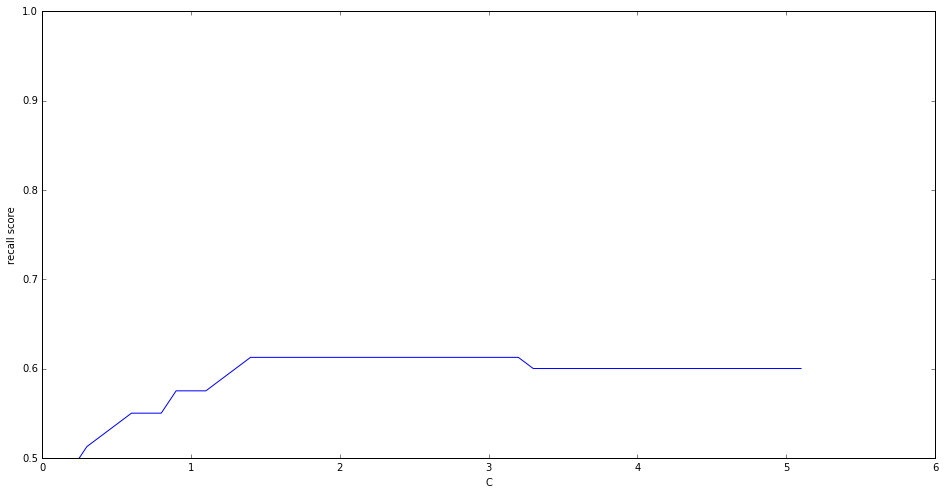

In [29]:
# explore hyperparameter C from 0.1 to 5.0 in increments of 0.1
C_start = 0.1
C_end   = 5.1
C_inc   = 0.1
C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0

# loop over C values, keeping track of best recall score
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C = C_val, random_state=42)
    lr_model_loop.fit(X_train,y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
    
    C_val += C_inc
    
best_score_C_val = C_values[ recall_scores.index( best_recall_score ) ]
print("First max val of {0:.3f} occurred at C = {1:.1f}".format(best_recall_score,best_score_C_val))

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(C_values, recall_scores)
plt.ylim(0.5,1)
plt.xlabel("C")
plt.ylabel("recall score")

#### Hmmm... this showed that playing with C has some effect . . . but not enough to reach 70%.


## Unbalanced Classes
#### We have 65% diabetes and 35% non-diabetes cases, is that imbalance an issue?  Repeat the previous loop with LogisticRegression hyperparameter class_weight='balanced'

First max val of 0.738 occurred at C = 0.3


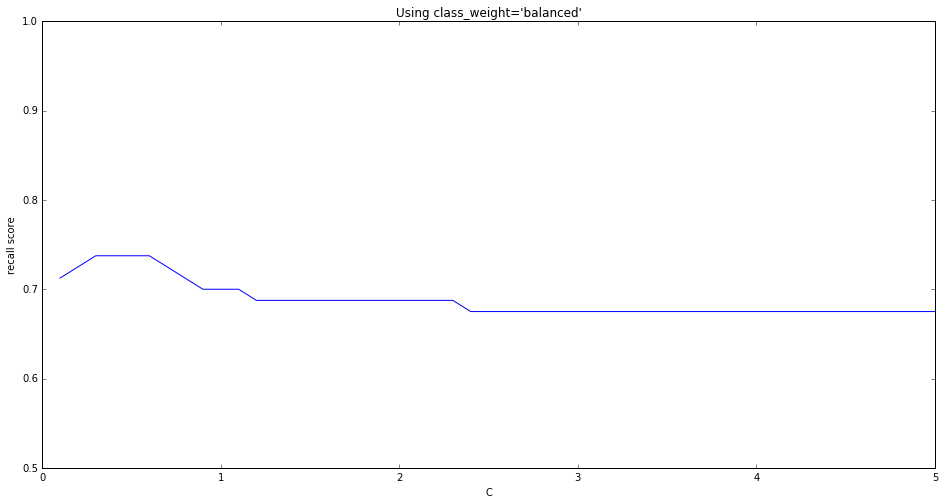

In [30]:
C_start = 0.1
C_end   = 5.0
C_inc   = 0.1
C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C=C_val, class_weight='balanced', random_state=42)
    lr_model_loop.fit(X_train,y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
    
    C_val += C_inc
    
best_score_C_val = C_values[recall_scores.index(best_recall_score)]
print("First max val of {0:.3f} occurred at C = {1:.1f}".format(best_recall_score,best_score_C_val))

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(C_values, recall_scores)
plt.title("Using class_weight='balanced'")
plt.ylim(0.5,1)
plt.xlabel("C")
plt.ylabel("recall score")

#### Take that best-score C value of 0.3 and use it to re-run a single model now using the class_weight='balanced' hyperparameter

In [31]:
lr_model = LogisticRegression(class_weight='balanced', C=best_score_C_val, random_state=42)
lr_model.fit(X_train,y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# Run metrics on it
print("Accuracy:  {0:.4f} \n".format(metrics.accuracy_score(y_test, lr_predict_test) ))
print(metrics.classification_report(y_test, lr_predict_test, labels=[1,0]))

Accuracy:  0.7143 

             precision    recall  f1-score   support

          1       0.57      0.74      0.64        80
          0       0.83      0.70      0.76       151

avg / total       0.74      0.71      0.72       231



Okay, that's good because Recall is now above 70% . . . but, we got best_score_C_val by actually running models on the **test** data.  So to test on a wider set of data is best, and that may mean trading off performance.  Time for . . . 
## Cross Validation 
### To clearly re-state the issue and why we are turning to CV, in the previous few cells we chose to dip into our *test* data in order to tune hyperparameter "C".  Using CV is one way to guard against the risks of this having "taught to the test", because with CV we will be splitting our data multiple times into different train and test batches.  

(Doing multiple splits will be better than a single 3-way split of our original data frame into, say, 50% Training data, 25% Validation/Tuning data and 25% Test data.

(Reminder:  This is a separate, additional value to doing Cross-validation beyond helping avoid over-fitting.)


#### K-fold Cross Validation:  divide the Training data into K-fold parts, loop through them, each time one fold is the Validation data, rest is trained on.  Then take the average best value for the tuning parameter.

Use the "CV" version of LogisticsRegression that has this functionality

### LogisticRegressionCV

In [32]:
from sklearn.linear_model import LogisticRegressionCV

# n_jobs = -1 means use all available cores, to run faster
# cv = 10 means make 10-folds within the Training set
# Cs = 3 means within each fold, make 3 attempts to find best tuning parameter
lr_cv_model = LogisticRegressionCV(n_jobs=-1, random_state=42, Cs=3, cv=10, refit=True, class_weight='balanced')
lr_cv_model.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=3, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

### Predict on the Test data

In [33]:
lr_cv_predict_test = lr_cv_model.predict(X_test)

# Run metrics on it
print("Accuracy:  {0:.4f} \n".format(metrics.accuracy_score(y_test, lr_cv_predict_test) ))
print(metrics.confusion_matrix(y_test, lr_cv_predict_test, labels=[1,0]))
print(metrics.classification_report(y_test, lr_cv_predict_test, labels=[1,0]))

Accuracy:  0.7013 

[[ 53  27]
 [ 42 109]]
             precision    recall  f1-score   support

          1       0.56      0.66      0.61        80
          0       0.80      0.72      0.76       151

avg / total       0.72      0.70      0.71       231



### NOTE:  This new Recall value of 66% is lower than the 74% above, but this model should perform better across a *wider* range of test data.